In [1]:

import tifffile
import numpy as np
import torch
import os
import random
import h5py
from tqdm import tqdm
import matplotlib.pyplot as plt

from sr_3dunet.utils.data_utils import random_crop_3d, random_crop_2d, augment_3d, augment_2d, preprocess, get_projection, get_rotated_img, crop_block

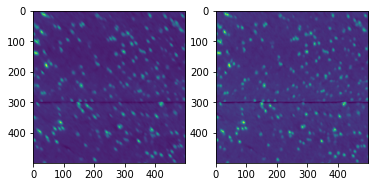

In [13]:
ims_path = '/share/home/wangwb/workspace/sr_3dunet/datasets/CJ4ROI1.ims'

h5 = h5py.File(ims_path, 'r')
img_total = h5['DataSet']['ResolutionLevel 0']['TimePoint 0']['Channel 0']['Data']

plt.subplot(121)
plt.imshow(img_total[0:500, 5000, 5000:5500])

ims_path = '/share/home/wangwb/workspace/sr_3dunet/datasets/cellbody/out_h5/output_res0.h5'
h5 = h5py.File(ims_path, 'r')
img_total = h5['DataSet']['ResolutionLevel 0']['TimePoint 0']['Channel 0']['Data']

plt.subplot(122)
plt.imshow(img_total[0:500, 5000, 5000:5500])

输出h5 截图

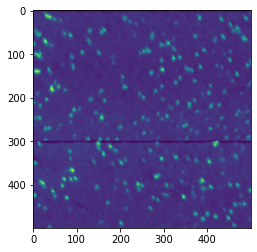

打印目录

In [6]:
import h5py

def print_h5_structure(h5_obj, level=0):
    for key in h5_obj.keys():
        print("  " * level + f"- {key}")
        if isinstance(h5_obj[key], h5py.Group):
            print_h5_structure(h5_obj[key], level + 1)

# 打开 h5 文件
h5_file = h5py.File('/share/home/wangwb/workspace/sr_3dunet/datasets/CJ4ROI1.ims', 'r')

# 打印 h5 文件的目录结构
print("HDF5 file structure:")
print_h5_structure(h5_file)

# 关闭 h5 文件
h5_file.close()

HDF5 file structure:
- DataSet
  - ResolutionLevel 0
    - TimePoint 0
      - Channel 0
        - Data
        - Histogram
        - Histogram1024
      - Channel 1
        - Data
        - Histogram
        - Histogram1024
  - ResolutionLevel 1
    - TimePoint 0
      - Channel 0
        - Data
        - Histogram
        - Histogram1024
      - Channel 1
        - Data
        - Histogram
        - Histogram1024
  - ResolutionLevel 2
    - TimePoint 0
      - Channel 0
        - Data
        - Histogram
        - Histogram1024
      - Channel 1
        - Data
        - Histogram
        - Histogram1024
  - ResolutionLevel 3
    - TimePoint 0
      - Channel 0
        - Data
        - Histogram
        - Histogram1024
      - Channel 1
        - Data
        - Histogram
        - Histogram1024
  - ResolutionLevel 4
    - TimePoint 0
      - Channel 0
        - Data
        - Histogram
        - Histogram1024
      - Channel 1
        - Data
        - Histogram
        - Histogram1024

In [10]:
import h5py

def print_h5_structure(h5_obj, level=0):
    for key in h5_obj.keys():
        print("  " * level + f"- {key}")
        if isinstance(h5_obj[key], h5py.Group):
            print_h5_structure(h5_obj[key], level + 1)

# 打开 h5 文件
h5_file = h5py.File('/share/home/wangwb/workspace/sr_3dunet/datasets/cellbody/out_h5/output_res0.h5', 'r')

# 打印 h5 文件的目录结构
print("HDF5 file structure:")
print_h5_structure(h5_file)

# 关闭 h5 文件
h5_file.close()

HDF5 file structure:
- DataSet
  - ResolutionLevel 0
    - TimePoint 0
      - Channel 0
        - Data


阈值设置为1000？

In [6]:
len = 128

tifffile.imsave('total.tif', img_total[200:200+len, 3000:3000+len, 3000:3000+len])

/tmp/ipykernel_1121403/936476501.py:3: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave('total.tif', img_total[200:200+len, 3000:3000+len, 3000:3000+len])
